<p style="align: center;"><img align=center src="https://user-images.githubusercontent.com/83309486/145721861-c579b83a-c817-4669-a8bf-49fca66a9ddc.png"/></p>


<h3 style="text-align: center;"><b>Домашнее задание. Осень 2022</b></h3>

In [29]:
from sklearn.metrics import roc_auc_score

In [53]:
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import pandas_profiling
from pandas_profiling.utils.cache import cache_file

from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, plot_confusion_matrix
from sklearn.ensemble import RandomForestClassifier

from sklearn.pipeline import make_pipeline
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import GridSearchCV

from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn.preprocessing import StandardScaler, RobustScaler, LabelEncoder, OneHotEncoder

# Первая часть. Исследование

## Работа с данными

In [41]:
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')

In [31]:

# Числовые признаки
num_cols = [
    'ClientPeriod',
    'MonthlySpending',
    'TotalSpent'
]

# Категориальные признаки
cat_cols = [
    'Sex',
    'IsSeniorCitizen',
    'HasPartner',
    'HasChild',
    'HasPhoneService',
    'HasMultiplePhoneNumbers',
    'HasInternetService',
    'HasOnlineSecurityService',
    'HasOnlineBackup',
    'HasDeviceProtection',
    'HasTechSupportAccess',
    'HasOnlineTV',
    'HasMovieSubscription',
    'HasContractPhone',
    'IsBillingPaperless',
    'PaymentMethod'
]

feature_cols = num_cols + cat_cols
target_col = 'Churn'

In [ ]:
train.info()

In [117]:
train.isna().sum()

ClientPeriod                0
MonthlySpending             0
TotalSpent                  0
Sex                         0
IsSeniorCitizen             0
HasPartner                  0
HasChild                    0
HasPhoneService             0
HasMultiplePhoneNumbers     0
HasInternetService          0
HasOnlineSecurityService    0
HasOnlineBackup             0
HasDeviceProtection         0
HasTechSupportAccess        0
HasOnlineTV                 0
HasMovieSubscription        0
HasContractPhone            0
IsBillingPaperless          0
PaymentMethod               0
Churn                       0
dtype: int64

In [42]:
train[cat_cols]=train[cat_cols].astype('object')
train[num_cols]=train[num_cols].astype('float64', errors='ignore')
train['TotalSpent'] = pd.to_numeric(train['TotalSpent'], errors='coerce')

## Анализ данных

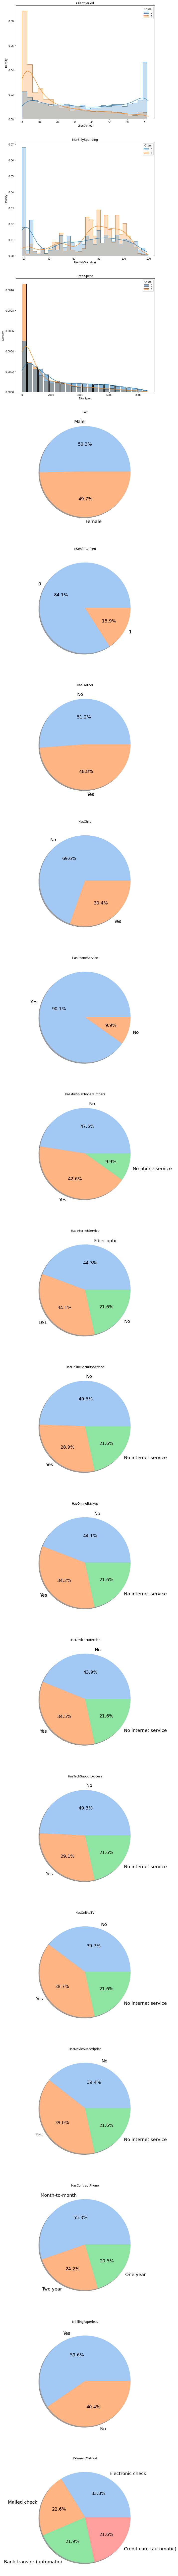

In [92]:
fig, axes = plt.subplots(19, 1, figsize=(10, 190))
for ax, col in zip(axes.flatten(), train.columns):
    ax.set_title(col)
    if col in cat_cols or col == target_col:
        colors = sns.color_palette('pastel')
        ax.pie(train[col].value_counts(), colors=colors, shadow = 'True', textprops = {'fontsize':18},  autopct="%1.1f%%", labels=train[col].value_counts().index)
    else:
        if col != 'TotalSpent':
            sns.histplot(train, x=col, shrink=.8, ax=ax, binwidth=3, element="step", hue=target_col, kde=True,
                                stat="density", common_norm=False,)
        else:
            sns.histplot(train, x=col, shrink=.8, ax=ax, hue=target_col, kde=True,
                                stat="density", common_norm=False,)

In [158]:
X, y = train[feature_cols], train[target_col]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Modeling

## LogisticRegression

In [14]:
numeric_preprocessor = Pipeline(
    steps=[
        ("imputation_mean", SimpleImputer(missing_values=np.nan, strategy="mean")),
        ("scaler", StandardScaler()),
    ]
)

categorical_preprocessor = Pipeline(
    steps=[
        (
            "imputation_constant",
            SimpleImputer(fill_value="missing", strategy="constant"),
        ),
        ("onehot", OneHotEncoder(handle_unknown="ignore")),
    ]
)

preprocessor = ColumnTransformer(
    [
        ("categorical", categorical_preprocessor, cat_cols),
        ("numerical", numeric_preprocessor, num_cols),
    ]
)

pipe = Pipeline(
    steps=[("preprocessor", preprocessor), ("classifier", RandomForestClassifier())]
)

param_grid = {
    "preprocessor__num__imputer__strategy": ["mean", "median"],
    "classifier__C": [0.1, 1.0, 10, 100],
}
grid_search = GridSearchCV(pipe, param_grid=param_grid, n_jobs=1)
grid_search

In [11]:
grid_search.fit(X_train, y_train)

In [ ]:
grid_search.predict(X_test, y_test)

## Catboost


In [98]:
from catboost import CatBoostClassifier, Pool, metrics, cv

In [108]:
train_pool = Pool(X, y, cat_features=cat_cols)

In [126]:
params = {
    'iterations': 500,
    'learning_rate': 0.1,
    'eval_metric': 'AUC:hints=skip_train~false',
    'random_seed': 42,
    'od_type': 'Iter',
    'od_wait': 40,
    'logging_level': 'Silent',
}

In [127]:
model = CatBoostClassifier(**params)

In [129]:
grid = {  'depth':[3,1,2,6,4,5,7,8,9,10],
          'iterations':[250,100,500,1000],
          'learning_rate':[0.03,0.001,0.01,0.1,0.2,0.3], 
          #'l2_leaf_reg':[3,1,5,10,100],
          #'border_count':[32,5,10,20,50,100,200],
          'thread_count':[16]}

grid_search_result = model.grid_search(grid, 
                                       train_pool,
                                       plot=True)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	loss: 0.8725759	best: 0.8725759 (0)	total: 1.69s	remaining: 6m 43s
1:	loss: 0.8606892	best: 0.8725759 (0)	total: 4.01s	remaining: 7m 56s
2:	loss: 0.8719931	best: 0.8725759 (0)	total: 6.77s	remaining: 8m 54s
3:	loss: 0.8736816	best: 0.8736816 (3)	total: 7.76s	remaining: 7m 38s
4:	loss: 0.8708921	best: 0.8736816 (3)	total: 8.51s	remaining: 6m 39s
5:	loss: 0.8733186	best: 0.8736816 (3)	total: 9.11s	remaining: 5m 55s
6:	loss: 0.8730583	best: 0.8736816 (3)	total: 10.1s	remaining: 5m 35s
7:	loss: 0.8319529	best: 0.8736816 (3)	total: 10.6s	remaining: 5m 7s
8:	loss: 0.8627861	best: 0.8736816 (3)	total: 11.4s	remaining: 4m 53s
9:	loss: 0.8735383	best: 0.8736816 (3)	total: 12.1s	remaining: 4m 37s
10:	loss: 0.8719764	best: 0.8736816 (3)	total: 12.6s	remaining: 4m 21s
11:	loss: 0.8724445	best: 0.8736816 (3)	total: 13.1s	remaining: 4m 8s
12:	loss: 0.8725759	best: 0.8736816 (3)	total: 14.8s	remaining: 4m 18s
13:	loss: 0.8606892	best: 0.8736816 (3)	total: 16.4s	remaining: 4m 24s
14:	loss: 0.873617

In [139]:
params.update(grid_search_result['params'])
model_cat = CatBoostClassifier(**params).fit(train_pool, plot=True)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

лучшее качество и параметры

## hplearn

In [163]:
from hpsklearn import HyperoptEstimator
from hpsklearn import any_classifier
from hpsklearn import any_preprocessing

In [161]:
preprossed_X = preprocessor.fit_transform(X)

In [165]:
model = HyperoptEstimator(classifier=any_classifier('cla'), preprocessing=any_preprocessing('pre'), algo=tpe.suggest, max_evals=10, trial_timeout=30)
model.fit(preprossed_X, y)

 83%|████████▎ | 5/6 [00:00<?, ?trial/s, best loss=?]

/opt/conda/lib/python3.8/site-packages/sklearn/ensemble/_gb.py:310: FutureWarning: The loss parameter name 'deviance' was deprecated in v1.1 and will be removed in version 1.3. Use the new parameter name 'log_loss' which is equivalent.
  warnings.warn(



 86%|████████▌ | 6/7 [00:00<?, ?trial/s, best loss=?]

Exception ignored on calling ctypes callback function
: 
<function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7f52bf2abe50>
Traceback (most recent call last):

  File "/opt/conda/lib/python3.8/site-packages/threadpoolctl.py", line 400, in match_module_callback

self._make_module_from_path(filepath)
  File "/opt/conda/lib/python3.8/site-packages/threadpoolctl.py", line 515, in _make_module_from_path

module = module_class(filepath, prefix, user_api, internal_api)
  File "/opt/conda/lib/python3.8/site-packages/threadpoolctl.py", line 606, in __init__

self.version = self.get_version()
  File "/opt/conda/lib/python3.8/site-packages/threadpoolctl.py", line 646, in get_version

config = get_config().split()
AttributeError
: 
'NoneType' object has no attribute 'split'


 88%|████████▊ | 7/8 [00:00<?, ?trial/s, best loss=?]

Exception ignored on calling ctypes callback function
: 
<function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7f52bf2abb80>
Traceback (most recent call last):

  File "/opt/conda/lib/python3.8/site-packages/threadpoolctl.py", line 400, in match_module_callback

self._make_module_from_path(filepath)
  File "/opt/conda/lib/python3.8/site-packages/threadpoolctl.py", line 515, in _make_module_from_path

module = module_class(filepath, prefix, user_api, internal_api)
  File "/opt/conda/lib/python3.8/site-packages/threadpoolctl.py", line 606, in __init__

self.version = self.get_version()
  File "/opt/conda/lib/python3.8/site-packages/threadpoolctl.py", line 646, in get_version

config = get_config().split()
AttributeError
: 
'NoneType' object has no attribute 'split'


100%|██████████| 10/10 [00:02<00:00,  2.50s/trial, best loss: 0.20719016083254493]


# Предсказания

In [166]:
best_model = model

In [172]:
X_test_data = pd.read_csv('./test.csv')
X_test_data[cat_cols]=X_test_data[cat_cols].astype('object')
X_test_data[num_cols]=X_test_data[num_cols].astype('float64', errors='ignore')
X_test_data['TotalSpent'] = pd.to_numeric(X_test_data['TotalSpent'], errors='coerce')

X_test_data = preprocessor.fit_transform(X_test_data)


submission = pd.read_csv('./submission.csv')

submission['Churn'] = best_model.predict(X_test_data)
submission.to_csv('./my_submission.csv', index=False)

## Kaggle

In [174]:
!kaggle competitions submit -c advanced-dls-spring-2021 -f my_submission.csv -m "New one"

Traceback (most recent call last):
  File "/opt/conda/bin/kaggle", line 5, in <module>
    from kaggle.cli import main
  File "/opt/conda/lib/python3.8/site-packages/kaggle/__init__.py", line 23, in <module>
    api.authenticate()
  File "/opt/conda/lib/python3.8/site-packages/kaggle/api/kaggle_api_extended.py", line 164, in authenticate
    raise IOError('Could not find {}. Make sure it\'s located in'
OSError: Could not find kaggle.json. Make sure it's located in /root/.kaggle. Or use the environment method.
